In [1]:
import sys
import pickle
sys.path.append('../..')
import pandas as pd
from datetime import datetime
from pgbm_model import pgbm_pred
import matplotlib.pyplot as plt
from preprocessing import get_nn_data
from lstm import build_model, make_pred
from plots_lstm import plot_loss, plot_comp 
from sklearn.metrics import mean_squared_error as mse 

In [2]:
CITY = 2611606
CITY_NAME = 'Recife'
STATE = 'PE'
FILENAME_DATA = f'../../data/dengue_{CITY}_cluster.csv'

In [3]:
df_dengue = pd.read_csv(FILENAME_DATA, index_col = 'Unnamed: 0' )
df_dengue.index = pd.to_datetime(df_dengue.index)
df_dengue

,casos_2614857,casos_est_2614857,casos_est_min_2614857,casos_est_max_2614857,p_rt1_2614857,p_inc100k_2614857,temp_min_2614857,temp_max_2614857,umid_min_2614857,pressao_min_2614857,...,casos_2613800,casos_est_2613800,casos_est_min_2613800,casos_est_max_2613800,p_rt1_2613800,p_inc100k_2613800,temp_min_2613800,temp_max_2613800,umid_min_2613800,pressao_min_2613800
2010-01-03,0,0.0,0,0,0.000000,0.00000,21.666667,29.666667,54.333333,1010.666667,...,0,0.0,0,0,0.000000,0.0000,22.666667,31.333333,48.000000,1010.666667
2010-01-10,0,0.0,0,0,0.000000,0.00000,22.000000,29.428571,53.142857,1010.714286,...,0,0.0,0,0,0.000000,0.0000,22.000000,30.857143,46.571429,1011.000000
2010-01-17,0,0.0,0,0,0.000000,0.00000,22.714286,29.857143,55.142857,1012.428571,...,0,0.0,0,0,0.000000,0.0000,22.142857,30.571429,46.857143,1012.714286
2010-01-24,0,0.0,0,0,0.000000,0.00000,21.142857,27.571429,62.142857,1011.285714,...,0,0.0,0,0,0.000000,0.0000,21.714286,30.285714,48.142857,1011.571429
2010-01-31,0,0.0,0,0,0.000000,0.00000,23.000000,30.000000,58.142857,1010.142857,...,0,0.0,0,0,0.000000,0.0000,22.428571,31.142857,49.000000,1010.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-29,1,1.0,1,1,0.503129,4.23316,21.857143,27.000000,71.480471,1014.142857,...,17,17.0,17,19,0.548564,94.0005,20.285714,25.428571,76.269171,1015.000000
2022-06-05,1,1.0,1,1,0.501632,4.23316,22.142857,27.000000,74.248829,1011.857143,...,11,11.0,11,14,0.169762,60.8239,20.857143,26.142857,74.331671,1013.000000
2022-06-12,3,3.0,3,3,0.857211,12.69950,21.714286,26.285714,74.289157,1013.142857,...,7,8.0,7,11,0.079502,44.2356,20.000000,24.714286,76.677300,1014.142857
2022-06-19,1,1.0,1,1,0.358644,4.23316,21.571429,25.571429,74.774829,1014.428571,...,5,7.0,5,17,0.131616,38.7061,20.000000,26.000000,71.428271,1015.428571


## Neural network model 

Parameters of the models:

In [4]:
END_DATE = '2021-06-01' # assign the last day used to evaluate the dengue model 

PREDICT_N = 4 # number of new days predicted
LOOK_BACK = 4 # number of last days used to make the prediction 
EPOCHS = 400
HIDDEN = 8
FEAT = df_dengue.shape[1] +1 # number of features

Let's train the model with the loss function == msle 

Compilation Time :  0.002701997756958008
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4, 131)]          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 4, 8)             8960      
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 4, 8)              0         
                                                                 
 lstm_1 (LSTM)               (None, 8)                 544       
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0

2023-01-17 09:06:09.137469: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


374/374 [==============================] - 3s 4ms/step - loss: 0.0147 - accuracy: 0.2781 - mape: 5463803.0000 - mse: 0.0261 - val_loss: 0.0076 - val_accuracy: 0.2537 - val_mape: 905171.4375 - val_mse: 0.0149
Epoch 2/400
374/374 [==============================] - 1s 3ms/step - loss: 0.0064 - accuracy: 0.2914 - mape: 1116946.7500 - mse: 0.0123 - val_loss: 0.0057 - val_accuracy: 0.1791 - val_mape: 1546130.8750 - val_mse: 0.0105
Epoch 3/400
374/374 [==============================] - 1s 3ms/step - loss: 0.0051 - accuracy: 0.2701 - mape: 978062.1875 - mse: 0.0096 - val_loss: 0.0048 - val_accuracy: 0.2985 - val_mape: 542777.8125 - val_mse: 0.0096
Epoch 4/400
374/374 [==============================] - 1s 3ms/step - loss: 0.0048 - accuracy: 0.2727 - mape: 1524611.2500 - mse: 0.0092 - val_loss: 0.0057 - val_accuracy: 0.2836 - val_mape: 1840149.0000 - val_mse: 0.0113
Epoch 5/400
374/374 [==============================] - 1s 3ms/step - loss: 0.0039 - accuracy: 0.2754 - mape: 1818384.3750 - mse: 0.

374/374 [==============================] - 1s 3ms/step - loss: 0.0022 - accuracy: 0.3824 - mape: 764511.0625 - mse: 0.0041 - val_loss: 0.0025 - val_accuracy: 0.4179 - val_mape: 31471.7695 - val_mse: 0.0052
Epoch 39/400
374/374 [==============================] - 1s 3ms/step - loss: 0.0019 - accuracy: 0.3422 - mape: 1026922.6250 - mse: 0.0035 - val_loss: 0.0032 - val_accuracy: 0.5224 - val_mape: 78046.1641 - val_mse: 0.0064
Epoch 40/400
374/374 [==============================] - 1s 3ms/step - loss: 0.0021 - accuracy: 0.4064 - mape: 1186335.0000 - mse: 0.0039 - val_loss: 0.0023 - val_accuracy: 0.2537 - val_mape: 1199854.2500 - val_mse: 0.0041
Epoch 41/400
374/374 [==============================] - 1s 3ms/step - loss: 0.0015 - accuracy: 0.3850 - mape: 818031.2500 - mse: 0.0029 - val_loss: 0.0028 - val_accuracy: 0.3881 - val_mape: 356122.1875 - val_mse: 0.0057
Epoch 42/400
374/374 [==============================] - 1s 3ms/step - loss: 0.0019 - accuracy: 0.3797 - mape: 985370.3750 - mse: 0.0

374/374 [==============================] - 1s 3ms/step - loss: 0.0016 - accuracy: 0.4412 - mape: 539538.1250 - mse: 0.0032 - val_loss: 0.0019 - val_accuracy: 0.4030 - val_mape: 461658.3750 - val_mse: 0.0036
Epoch 76/400
374/374 [==============================] - 1s 3ms/step - loss: 0.0014 - accuracy: 0.4171 - mape: 802813.7500 - mse: 0.0026 - val_loss: 0.0026 - val_accuracy: 0.4627 - val_mape: 98.0815 - val_mse: 0.0053
Epoch 77/400
374/374 [==============================] - 1s 3ms/step - loss: 0.0015 - accuracy: 0.3984 - mape: 772490.4375 - mse: 0.0028 - val_loss: 0.0020 - val_accuracy: 0.3881 - val_mape: 367759.0312 - val_mse: 0.0038
Epoch 78/400
374/374 [==============================] - 1s 3ms/step - loss: 0.0015 - accuracy: 0.3957 - mape: 1169439.0000 - mse: 0.0027 - val_loss: 0.0015 - val_accuracy: 0.3731 - val_mape: 275836.3125 - val_mse: 0.0029
Epoch 79/400
374/374 [==============================] - 1s 4ms/step - loss: 0.0015 - accuracy: 0.4144 - mape: 601475.6875 - mse: 0.0029 

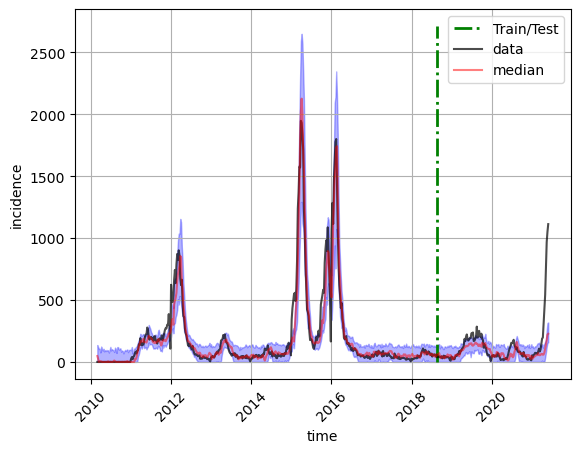

CPU times: user 4min 11s, sys: 19.2 s, total: 4min 30s
Wall time: 3min 49s


In [5]:
%%time

model = build_model(hidden = HIDDEN, features = FEAT, predict_n = PREDICT_N, look_back=LOOK_BACK, batch_size=1, loss = 'msle')

metrics_msle, hist_msle, m_train, m_val = make_pred(model, CITY, doenca = 'dengue', epochs = EPOCHS, end_train_date = None, 
                    ratio= 0.75, end_date = END_DATE,
                     predict_n = PREDICT_N, look_back =  LOOK_BACK, label = 'msle', filename = FILENAME_DATA)

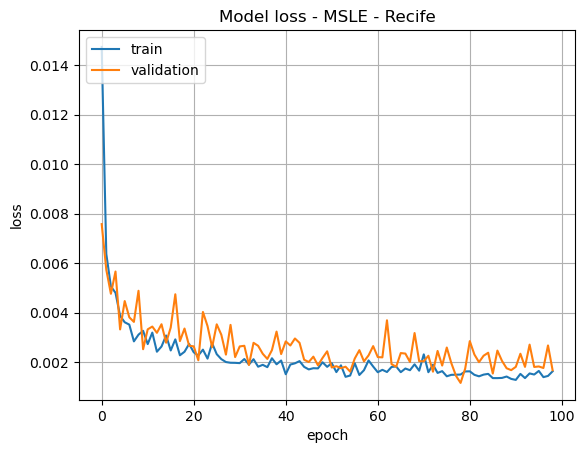

In [6]:
plot_loss(hist_msle, title = 'Model loss - MSLE - Recife')

To specialize our lstm dengue model to predict better the peak of cases we propose a custom loss function. This function gives a weight of 10 to the predictions of ascending cases in the train data. 

This weight is given to the observations in the training data, where the fourth value is bigger than the second value of the target data. (Remember it is an array of length four since we forecast the next 4 observations).  

This functions is defined as: 

```
def custom_loss_msle(p = 1):
    """
    :param p: 
    """
    
    def my_loss_msle(y_true, y_pred):
        """
        :param y_true:
        :param y_pred: 
        """

        def f1(): 
            
            loss = tf.math.log(tf.math.add(y_true, 1)/ tf.math.add(y_pred, 1))
    
            loss = tf.square(loss)
        
            return tf.multiply(loss, p) 
        
        def f2(): 
            
            loss = tf.math.log(tf.math.add(y_true, 1)/ tf.math.add(y_pred, 1))
    
            loss = tf.square(loss)
        
            return loss

        msle = tf.cond(tf.less(tf.gather(y_true, 0)[1],tf.gather(y_true, 0)[3]) , 
                                     true_fn = f1,
                                     false_fn = f2 )

        return tf.reduce_mean(msle) 
    
    return my_loss_msle 
```

Let's train the model with a custom loss function:

Compilation Time :  0.0021257400512695312
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4, 131)]          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 4, 8)             8960      
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 4, 8)              0         
                                                                 
 lstm_1 (LSTM)               (None, 8)                 544       
                                                                 
 dropout_2 (Dropout)         (None, 8)               

374/374 [==============================] - 1s 4ms/step - loss: 0.0099 - accuracy: 0.3369 - mape: 2580393.0000 - mse: 0.0047 - val_loss: 0.0212 - val_accuracy: 0.3284 - val_mape: 280570.5000 - val_mse: 0.0061
Epoch 32/400
374/374 [==============================] - 1s 4ms/step - loss: 0.0126 - accuracy: 0.3182 - mape: 2236528.0000 - mse: 0.0053 - val_loss: 0.0186 - val_accuracy: 0.3731 - val_mape: 829845.9375 - val_mse: 0.0044
Epoch 33/400
374/374 [==============================] - 1s 4ms/step - loss: 0.0119 - accuracy: 0.3048 - mape: 3063877.2500 - mse: 0.0049 - val_loss: 0.0198 - val_accuracy: 0.2985 - val_mape: 1695134.7500 - val_mse: 0.0048
Epoch 34/400
374/374 [==============================] - 1s 4ms/step - loss: 0.0110 - accuracy: 0.3289 - mape: 2213564.0000 - mse: 0.0051 - val_loss: 0.0164 - val_accuracy: 0.4030 - val_mape: 2499897.5000 - val_mse: 0.0061
Epoch 35/400
374/374 [==============================] - 1s 4ms/step - loss: 0.0105 - accuracy: 0.2888 - mape: 2875412.2500 - ms

374/374 [==============================] - 1s 4ms/step - loss: 0.0104 - accuracy: 0.2701 - mape: 2334975.2500 - mse: 0.0050 - val_loss: 0.0196 - val_accuracy: 0.3284 - val_mape: 1152129.8750 - val_mse: 0.0072
Epoch 69/400
374/374 [==============================] - 1s 4ms/step - loss: 0.0094 - accuracy: 0.3476 - mape: 1884595.5000 - mse: 0.0045 - val_loss: 0.0394 - val_accuracy: 0.2985 - val_mape: 1084959.2500 - val_mse: 0.0111
Epoch 70/400
374/374 [==============================] - 1s 4ms/step - loss: 0.0095 - accuracy: 0.3182 - mape: 1914603.7500 - mse: 0.0045 - val_loss: 0.0134 - val_accuracy: 0.3881 - val_mape: 1775219.8750 - val_mse: 0.0035
Epoch 71/400
374/374 [==============================] - 1s 4ms/step - loss: 0.0090 - accuracy: 0.3128 - mape: 2010869.8750 - mse: 0.0051 - val_loss: 0.0147 - val_accuracy: 0.2836 - val_mape: 1082628.0000 - val_mse: 0.0052
Epoch 72/400
374/374 [==============================] - 1s 4ms/step - loss: 0.0073 - accuracy: 0.2754 - mape: 2473882.5000 - 

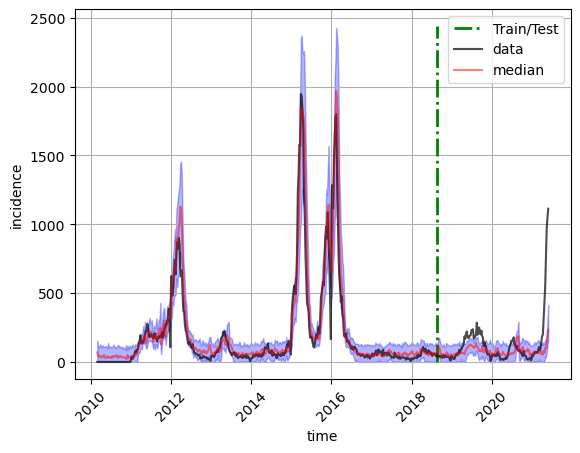

In [7]:
from lstm import custom_loss_msle

model = build_model(hidden = HIDDEN, features = FEAT, predict_n = PREDICT_N, look_back=LOOK_BACK, batch_size=1, loss = custom_loss_msle(p=10))

metrics_c_msle, hist_c_msle, m_c_train, m_c_val = make_pred(model, CITY, doenca = 'dengue', epochs = EPOCHS, end_train_date = None, 
                    ratio= 0.75, end_date = END_DATE,
                     predict_n = PREDICT_N, look_back =  LOOK_BACK, label = 'custom_msle', filename = FILENAME_DATA)

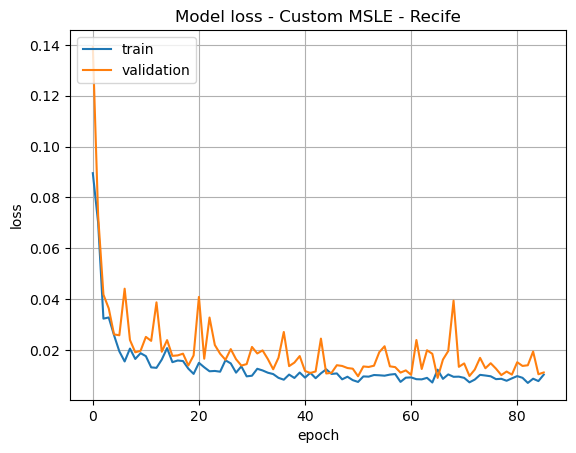

In [8]:
plot_loss(hist_c_msle, title = 'Model loss - Custom MSLE - Recife')

Comparing the performance of the strategies:

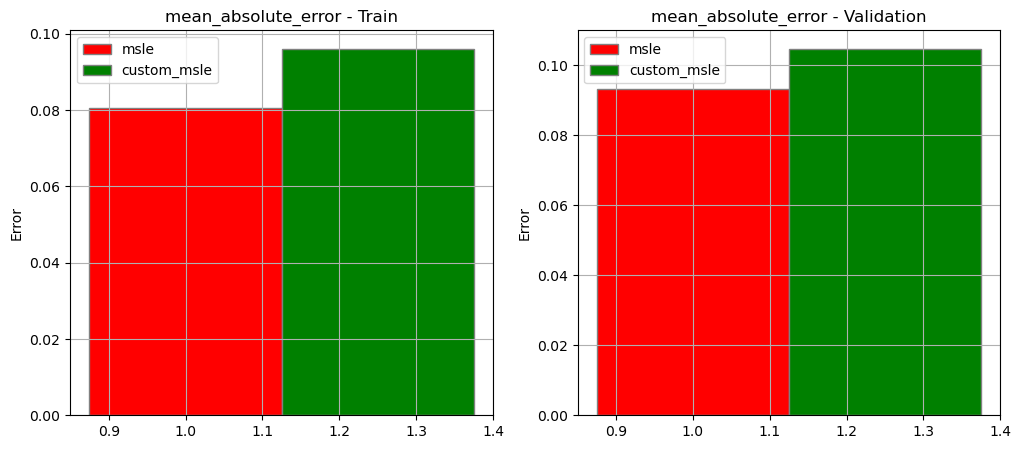

In [9]:
plot_comp(m_train, m_c_train,m_val, m_c_val, metric = 'mean_absolute_error')

Now, let's retrain the models with all the data available to apply the transfer learning step later:

Compilation Time :  0.0017647743225097656
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 4, 131)]          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 4, 8)             8960      
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 4, 8)              0         
                                                                 
 lstm_1 (LSTM)               (None, 8)                 544       
                                                                 
 dropout_2 (Dropout)         (None, 8)               

498/498 [==============================] - 3s 6ms/step - loss: 0.0019 - accuracy: 0.3896 - mape: 718387.1250 - mse: 0.0035 - val_loss: 0.0024 - val_accuracy: 0.3708 - val_mape: 46940.8164 - val_mse: 0.0042
Epoch 32/400
498/498 [==============================] - 3s 6ms/step - loss: 0.0017 - accuracy: 0.3956 - mape: 340491.0938 - mse: 0.0032 - val_loss: 0.0021 - val_accuracy: 0.3146 - val_mape: 230506.3594 - val_mse: 0.0036
Epoch 33/400
498/498 [==============================] - 3s 6ms/step - loss: 0.0017 - accuracy: 0.3594 - mape: 525433.9375 - mse: 0.0032 - val_loss: 0.0037 - val_accuracy: 0.2809 - val_mape: 98470.5859 - val_mse: 0.0065
Epoch 34/400
498/498 [==============================] - 3s 6ms/step - loss: 0.0018 - accuracy: 0.3635 - mape: 739392.1875 - mse: 0.0034 - val_loss: 0.0035 - val_accuracy: 0.3820 - val_mape: 212695.5781 - val_mse: 0.0062
Epoch 35/400
498/498 [==============================] - 3s 6ms/step - loss: 0.0018 - accuracy: 0.3554 - mape: 392805.4688 - mse: 0.0033

498/498 [==============================] - 3s 5ms/step - loss: 0.0017 - accuracy: 0.4096 - mape: 535049.6250 - mse: 0.0032 - val_loss: 0.0022 - val_accuracy: 0.3933 - val_mape: 63.4184 - val_mse: 0.0043
Epoch 69/400
498/498 [==============================] - 3s 5ms/step - loss: 0.0017 - accuracy: 0.4056 - mape: 298980.6875 - mse: 0.0033 - val_loss: 0.0025 - val_accuracy: 0.3371 - val_mape: 322598.8750 - val_mse: 0.0049
Epoch 70/400
498/498 [==============================] - 3s 5ms/step - loss: 0.0014 - accuracy: 0.3755 - mape: 596674.6875 - mse: 0.0026 - val_loss: 0.0019 - val_accuracy: 0.2697 - val_mape: 277291.9688 - val_mse: 0.0034
Epoch 71/400
498/498 [==============================] - 3s 6ms/step - loss: 0.0012 - accuracy: 0.4297 - mape: 556099.1875 - mse: 0.0021 - val_loss: 0.0023 - val_accuracy: 0.3708 - val_mape: 65.9072 - val_mse: 0.0039
Epoch 72/400
498/498 [==============================] - 3s 5ms/step - loss: 0.0015 - accuracy: 0.3775 - mape: 392115.7812 - mse: 0.0029 - val

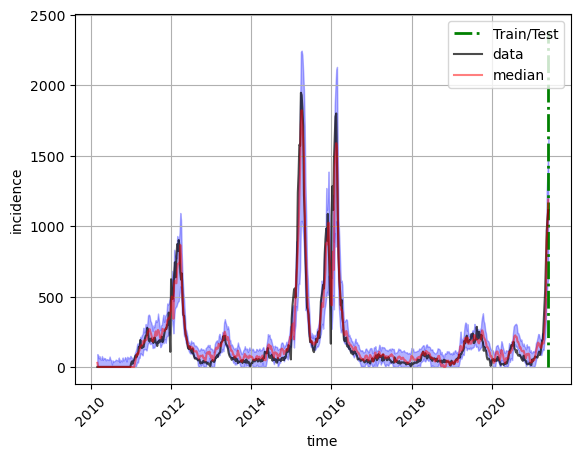

In [10]:
model = build_model(hidden = HIDDEN, features = FEAT, predict_n = PREDICT_N, look_back=LOOK_BACK, batch_size=1, loss = 'msle')

m_msle_all, h_msle_all, m_train_all, m_val_all = make_pred(model, CITY, doenca = 'dengue', epochs = EPOCHS, end_train_date = None, 
                    ratio= 1.0, end_date = END_DATE,
                     predict_n = PREDICT_N, look_back =  LOOK_BACK, label = 'msle_all',  filename = FILENAME_DATA)

Compilation Time :  0.0028069019317626953
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 4, 131)]          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 4, 8)             8960      
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 4, 8)              0         
                                                                 
 lstm_1 (LSTM)               (None, 8)                 544       
                                                                 
 dropout_2 (Dropout)         (None, 8)               

498/498 [==============================] - 2s 3ms/step - loss: 0.0097 - accuracy: 0.3313 - mape: 1473242.3750 - mse: 0.0041 - val_loss: 0.0219 - val_accuracy: 0.3146 - val_mape: 72.6294 - val_mse: 0.0065
Epoch 32/400
498/498 [==============================] - 2s 3ms/step - loss: 0.0124 - accuracy: 0.3333 - mape: 1593845.5000 - mse: 0.0044 - val_loss: 0.0228 - val_accuracy: 0.3034 - val_mape: 178814.5000 - val_mse: 0.0064
Epoch 33/400
498/498 [==============================] - 2s 3ms/step - loss: 0.0119 - accuracy: 0.3213 - mape: 1501657.3750 - mse: 0.0049 - val_loss: 0.0226 - val_accuracy: 0.3034 - val_mape: 307362.1875 - val_mse: 0.0057
Epoch 34/400
498/498 [==============================] - 2s 4ms/step - loss: 0.0081 - accuracy: 0.3233 - mape: 1716690.6250 - mse: 0.0035 - val_loss: 0.0207 - val_accuracy: 0.2809 - val_mape: 465275.5938 - val_mse: 0.0052
Epoch 35/400
498/498 [==============================] - 2s 4ms/step - loss: 0.0103 - accuracy: 0.3534 - mape: 774069.1250 - mse: 0.00

498/498 [==============================] - 2s 4ms/step - loss: 0.0092 - accuracy: 0.3373 - mape: 1316763.6250 - mse: 0.0039 - val_loss: 0.0132 - val_accuracy: 0.3146 - val_mape: 39783.9922 - val_mse: 0.0039
Epoch 69/400
498/498 [==============================] - 2s 3ms/step - loss: 0.0073 - accuracy: 0.3494 - mape: 1466860.1250 - mse: 0.0029 - val_loss: 0.0121 - val_accuracy: 0.2472 - val_mape: 995619.0625 - val_mse: 0.0035
Epoch 70/400
498/498 [==============================] - 2s 3ms/step - loss: 0.0083 - accuracy: 0.3574 - mape: 1684368.2500 - mse: 0.0033 - val_loss: 0.0128 - val_accuracy: 0.3034 - val_mape: 292822.1875 - val_mse: 0.0037
Epoch 71/400
498/498 [==============================] - 2s 4ms/step - loss: 0.0098 - accuracy: 0.3534 - mape: 1430239.3750 - mse: 0.0039 - val_loss: 0.0129 - val_accuracy: 0.3034 - val_mape: 53453.9844 - val_mse: 0.0055
Epoch 72/400
498/498 [==============================] - 2s 4ms/step - loss: 0.0087 - accuracy: 0.3414 - mape: 1203016.3750 - mse: 0

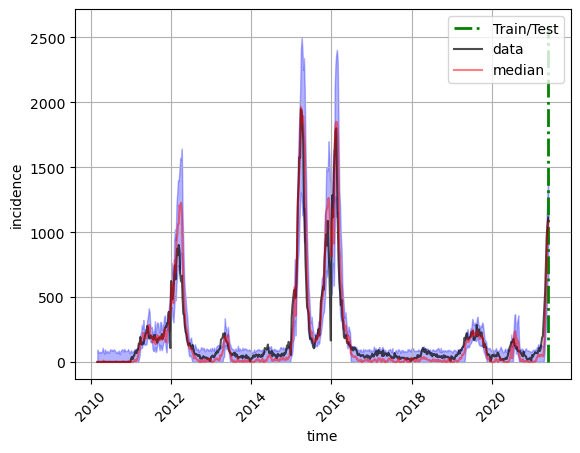

In [11]:
model = build_model(hidden = HIDDEN, features = FEAT, predict_n = PREDICT_N, look_back=LOOK_BACK, batch_size=1, loss = custom_loss_msle(p=10))

m_c_msle_all, h_c_msle_all, m_c_train_all, m_c_val_all = make_pred(model, CITY, doenca = 'dengue', epochs = EPOCHS, end_train_date = None, 
                    ratio= 1.0, end_date = END_DATE,
                     predict_n = PREDICT_N, look_back =  LOOK_BACK, label = 'custom_msle_all',  filename = FILENAME_DATA)

PGBM model

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Estimator 0/100, Train metric: 308.4223
Estimator 1/100, Train metric: 281.5404
Estimator 2/100, Train metric: 257.2249
Estimator 3/100, Train metric: 235.0807
Estimator 4/100, Train metric: 215.1149
Estimator 5/100, Train metric: 197.1220
Estimator 6/100, Train metric: 180.5314
Estimator 7/100, Train metric: 165.5049
Estimator 8/100, Train metric: 151.9765
Estimator 9/100, Train metric: 139.4327
Estimator 10/100, Train metric: 128.0120
Estimator 11/100, Train metric: 117.6030
Estimator 12/100, Train metric: 108.1161
Estimator 13/100, Train metric: 99.4747
Estimator 14/100, Train metric: 91.4895
Estimator 15/100, Train metric: 84.2470
Estimator 16/100, Train metric: 77.4173
Estimator 17/100, Train metric: 71.4035
Estimator 18/100, Train metric: 65.7408
Estimator 19/100, Train metric: 60.5635
Estimator 20/100, Train metric: 55.8504
Estimator 21/100, Train metric: 51.5292
Estimator 22/100, Train metric: 47.6627
Estimator 23/100, Train metric: 44.1654
Estimator 24/100, Train metric: 40.86

Estimator 8/100, Train metric: 157.1696
Estimator 9/100, Train metric: 144.9423
Estimator 10/100, Train metric: 133.7129
Estimator 11/100, Train metric: 123.5058
Estimator 12/100, Train metric: 114.4057
Estimator 13/100, Train metric: 106.0086
Estimator 14/100, Train metric: 98.1499
Estimator 15/100, Train metric: 91.1217
Estimator 16/100, Train metric: 84.2319
Estimator 17/100, Train metric: 78.0073
Estimator 18/100, Train metric: 72.5327
Estimator 19/100, Train metric: 67.3779
Estimator 20/100, Train metric: 62.7582
Estimator 21/100, Train metric: 58.5468
Estimator 22/100, Train metric: 54.7564
Estimator 23/100, Train metric: 51.3059
Estimator 24/100, Train metric: 48.1834
Estimator 25/100, Train metric: 44.9761
Estimator 26/100, Train metric: 41.9554
Estimator 27/100, Train metric: 39.2049
Estimator 28/100, Train metric: 36.7091
Estimator 29/100, Train metric: 34.4800
Estimator 30/100, Train metric: 32.2166
Estimator 31/100, Train metric: 30.3845
Estimator 32/100, Train metric: 28.6

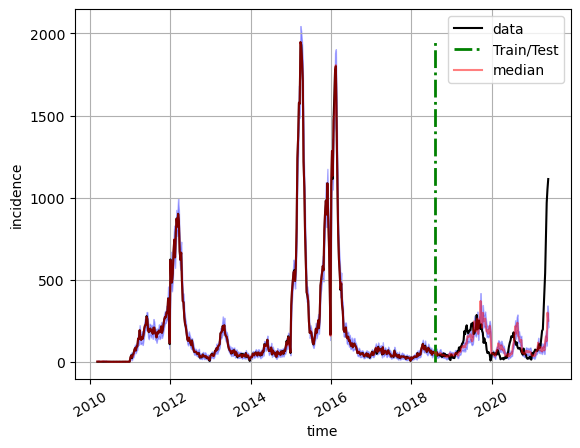

In [12]:

preds, preds25, preds975, X_train, targets = pgbm_pred(CITY, STATE, predict_n = PREDICT_N, look_back = LOOK_BACK,
                                                           doenca = 'dengue', ratio = 0.75, ini_date = None,
                                                           end_date = END_DATE, label = 'train_test',  filename = FILENAME_DATA)

Estimator 0/100, Train metric: 279.9304
Estimator 1/100, Train metric: 255.4032
Estimator 2/100, Train metric: 233.3095
Estimator 3/100, Train metric: 213.2495
Estimator 4/100, Train metric: 195.1809
Estimator 5/100, Train metric: 178.9151
Estimator 6/100, Train metric: 164.0932
Estimator 7/100, Train metric: 150.4146
Estimator 8/100, Train metric: 137.8039
Estimator 9/100, Train metric: 126.4493
Estimator 10/100, Train metric: 116.1440
Estimator 11/100, Train metric: 106.7651
Estimator 12/100, Train metric: 98.1271
Estimator 13/100, Train metric: 90.1865
Estimator 14/100, Train metric: 83.0401
Estimator 15/100, Train metric: 76.6521
Estimator 16/100, Train metric: 70.7367
Estimator 17/100, Train metric: 65.2328
Estimator 18/100, Train metric: 60.2555
Estimator 19/100, Train metric: 55.7638
Estimator 20/100, Train metric: 51.6883
Estimator 21/100, Train metric: 47.8010
Estimator 22/100, Train metric: 44.2205
Estimator 23/100, Train metric: 41.0429
Estimator 24/100, Train metric: 38.191

Estimator 8/100, Train metric: 142.3354
Estimator 9/100, Train metric: 131.1295
Estimator 10/100, Train metric: 120.9639
Estimator 11/100, Train metric: 111.6133
Estimator 12/100, Train metric: 103.2082
Estimator 13/100, Train metric: 95.6409
Estimator 14/100, Train metric: 88.6261
Estimator 15/100, Train metric: 82.3926
Estimator 16/100, Train metric: 76.6582
Estimator 17/100, Train metric: 71.2510
Estimator 18/100, Train metric: 66.4881
Estimator 19/100, Train metric: 61.8344
Estimator 20/100, Train metric: 57.6116
Estimator 21/100, Train metric: 53.7244
Estimator 22/100, Train metric: 50.2161
Estimator 23/100, Train metric: 46.9735
Estimator 24/100, Train metric: 44.0083
Estimator 25/100, Train metric: 41.3775
Estimator 26/100, Train metric: 38.9131
Estimator 27/100, Train metric: 36.7049
Estimator 28/100, Train metric: 34.5622
Estimator 29/100, Train metric: 32.6324
Estimator 30/100, Train metric: 30.8635
Estimator 31/100, Train metric: 29.2447
Estimator 32/100, Train metric: 27.77

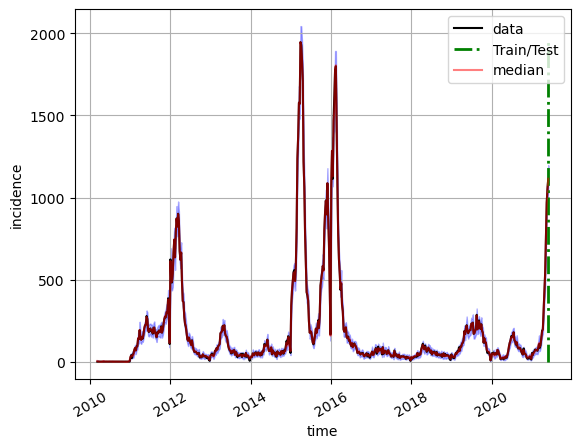

In [13]:
preds, preds25, preds975, X_train, targets = pgbm_pred(CITY, STATE, PREDICT_N, LOOK_BACK, doenca = 'dengue', ini_date = None, end_train_date = END_DATE, end_date = END_DATE,  filename = FILENAME_DATA)
   